# 第3.1章 高斯消去法

### 注明

该文档仅仅为测试高斯消去法，如果实际使用的时候，建议请直接使用封装好的库，例如numpy。

除非你的项目就是优化线性方程求解器。

In [1]:
import numpy as np
import time
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from numpy import round

## 高斯消去法的代码

In [2]:
def gaussian_elimination(A, b, perform_pivot=False, ptwise=True, precision=16):
    
    # A是系数矩阵，b是常数项向量
    n = len(A)
    
    for i in range(n):
        if perform_pivot:
            # 选择列主元并标准化该行
            pivot = np.abs(A[i][i])
            pivot_row = i 
            for row in range(i+1, n):
                if np.abs(A[row,i]) > pivot:
                    pivot = np.abs(A[row,i])
                    pivot_row = row
            
            if pivot_row != i:
                pivot_values = np.copy(A[pivot_row,:])
                A[pivot_row,:] = np.copy(A[i,:])
                A[i,:] = np.copy(pivot_values)
                bi = b[i]
                b[i] = b[pivot_row]
                b[pivot_row] = bi
        
        # 消除下方元素
        for row in range(i+1, n):
            factor = round(A[row,i] / A[i,i], precision)
            if ptwise:
                for col in range(i,n):
                    A[row,col] = round(A[row,col] - factor*A[i,col],precision)
            else:
                A[row,:] = round(A[row,:] - factor * A[i,:], precision)
            b[row] = round(b[row] -  factor * b[i], precision)

    # 回代求解
    x = np.zeros(n)
    x[n-1] = round(b[n-1]/A[n-1,n-1], precision)
    for i in range(n-2, -1, -1):
        # 我们已经简化了这里的有效数字问题
        x[i] = round(round(b[i] - round(np.dot(A[i,(i+1):], x[(i+1):]),precision),precision) / A[i,i], precision)

    return x, A, b

## 测试讲义里的例子

In [3]:
A = np.array([[1,1,1],[0,4,-1],[2,-2,1]])*1.0
b = np.array([6,5,1])*1.0

x_exact = np.linalg.solve(A,b)
print("numpy给的解：")
print(x_exact)
print()

x, U, _ = gaussian_elimination(A, b, perform_pivot=False)
print("上面代码的解：")
print(x)
print()

print("消去法得到的上三角矩阵：")
print(U)

numpy给的解：
[1. 2. 3.]

上面代码的解：
[1. 2. 3.]

消去法得到的上三角矩阵：
[[ 1.  1.  1.]
 [ 0.  4. -1.]
 [ 0.  0. -2.]]


## 测试运行时间和矩阵大小的关系

In [4]:
# unit test for codes
np.random.seed(1)

n_min = 50
n_max = 100
n_step = 2

n_list = np.array(np.arange(n_min,n_max,n_step))
ε = 1.0e-7

for i in range(len(n_list)):
    n = n_list[i]
    A = np.random.randn(n,n)
    b = np.random.randn(n)
    # 高斯顺序消去法
    x1,_,_ = gaussian_elimination(A.copy(), b.copy(), perform_pivot=False, ptwise=True)
    # 高斯顺序消去法（代码版本2）
    x2,_,_ = gaussian_elimination(A.copy(), b.copy(), perform_pivot=False, ptwise=False)
    # 高斯列主元素消去法
    x3,_,_ = gaussian_elimination(A.copy(), b.copy(), perform_pivot=True, ptwise=False)
    # numpy的解
    x_numpy = np.linalg.solve(A,b)
    assert np.linalg.norm(x1 - x_numpy) < ε
    assert np.linalg.norm(x2 - x_numpy) < ε
    assert np.linalg.norm(x3 - x_numpy) < ε 

In [5]:
n_min = 50
n_max = 100
n_step = 10
repeat = 40
seed = 1

n_list = np.array(np.arange(n_min,n_max,n_step))
# 记录运行的时间
time_list = np.zeros(len(n_list))
time_list_2 = np.zeros(len(n_list)) 
time_numpy = np.zeros(len(n_list))

np.random.seed(seed)

for i in range(len(n_list)):
    n = n_list[i]
    A = np.random.rand(n,n)
    b = np.random.rand(n)
    t = time.time()
    for k in range(repeat):
        x,_,_ = gaussian_elimination(A.copy(), b.copy(), perform_pivot=False, ptwise=True, precision=16)
    time_list[i] = (time.time() - t)/repeat

np.random.seed(seed)

for i in range(len(n_list)):
    n = n_list[i]
    A = np.random.rand(n,n)
    b = np.random.rand(n)
    t = time.time()
    for k in range(repeat):
        x,_,_ =gaussian_elimination(A.copy(), b.copy(), perform_pivot=False, ptwise=False, precision=16)
    time_list_2[i] = (time.time() - t)/repeat

np.random.seed(seed)

for i in range(len(n_list)):
    n = n_list[i]
    A = np.random.rand(n,n)
    b = np.random.rand(n)
    t = time.time()
    for k in range(repeat):
        x = np.linalg.solve(A.copy(), b.copy())
    time_numpy[i] = (time.time() - t)/repeat

In [6]:
# 创建模拟实验的数据集
X = np.log10(n_list).reshape(-1, 1) 
y1 = np.log10(time_list)
y2 = np.log10(time_list_2)
y3 = np.log10(time_numpy)

# 创建线性回归模型实例
model1 = LinearRegression()
model1.fit(X, y1)
model2 = LinearRegression()
model2.fit(X, y2)
model3 = LinearRegression()
model3.fit(X, y3)

# 打印模型的系数
print("高斯消去法（版本1：自己写loop）")
print("Coefficient: {:.3f}\n".format(model1.coef_[0]))

print("高斯消去法（版本2：使用向量运算）")
print("Coefficient: {:.3f}\n".format(model2.coef_[0]))

print("高斯消去法（numpy版本）")
print("Coefficient: {:.3f}\n".format(model3.coef_[0]))

# 进行预测
X_new = np.log10(np.array(np.arange(n_min-3,n_max+3,1))).reshape(-1, 1)
y1_predict = model1.predict(X_new)
y2_predict = model2.predict(X_new)
y3_predict = model3.predict(X_new)

高斯消去法（版本1：自己写loop）
Coefficient: 2.929

高斯消去法（版本2：使用向量运算）
Coefficient: 2.039

高斯消去法（numpy版本）
Coefficient: 1.981



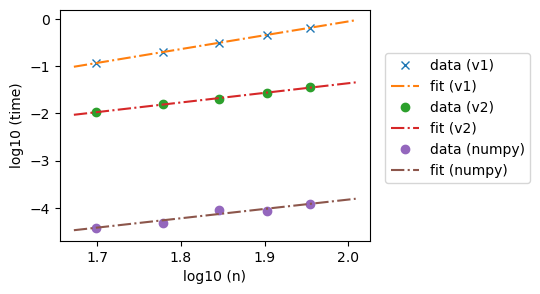

In [7]:
plt.figure(figsize=(4,3))
plt.plot(np.log10(n_list), np.log10(time_list), 'x', label="data (v1)") 
plt.plot(X_new, y1_predict, '-.',label="fit (v1)")

plt.plot(np.log10(n_list), np.log10(time_list_2),'o', label="data (v2)") 
plt.plot(X_new, y2_predict, '-.',label="fit (v2)")

plt.plot(np.log10(n_list), np.log10(time_numpy),'o', label="data (numpy)") 
plt.plot(X_new, y3_predict, '-.',label="fit (numpy)")

plt.legend(loc=(1.05,0.25))
plt.xlabel('log10 (n)')
plt.ylabel('log10 (time)')
plt.show()

## 实验的结论：

理论上时间和矩阵大小应该呈现 $\text{运行时间} = \mathcal{O}(n^3)$（见第一个版本的高斯消去法）

现实中，时间和矩阵大小的关系有可能在一定区间可以比这个好（例如我们优化了for loop）（见第二个版本的高斯消去法）

一般而言，对于一定的参数区间，封装好的库未必满足理论的数量阶，但实际效果会更好（见numpy的版本）

**结论**：理论和现实的实验存在一定的界限；理论的复杂度一般而言是在$n$比较大的时候，才更有可能能被验证成功。

## 列主元素消去法

In [8]:
A0 = np.array([[ 0.001, 2.000, 3.000],
               [-1.000, 3.712, 4.623],
               [-2.000, 1.072, 5.643]])
b0 = np.array([1.0, 2.0, 3.0])
x_numpy = np.linalg.solve(A0.copy(),b0.copy())
print(round(x_numpy, 5))

[-0.4904  -0.05104  0.36752]


In [9]:
x2, U2, b2 = gaussian_elimination(A0.copy(), b0.copy(), perform_pivot=True, ptwise=False, precision=4)
print("使用列主元素消元的解为：")
print(x2)
print("误差={:.4f}".format(np.linalg.norm(x2 - x_numpy)))

使用列主元素消元的解为：
[-0.4902 -0.0511  0.3676]
误差=0.0002


In [10]:
x3, U3, b3 = gaussian_elimination(A0.copy(), b0.copy(), perform_pivot=False, ptwise=False, precision=4)
print("不使用行交换的解为：")
print(x3)
print("误差={:.4f}".format(np.linalg.norm(x3 - x_numpy)))

不使用行交换的解为：
[-0.4    -0.0503  0.367 ]
误差=0.0904
